# 7. Semantic segmentation

In [ ]:
!git clone https://github.com/Bjarten/early-stopping-pytorch.git early_stopping
import os
os.chdir("/content/early_stopping")
!pip install -r requirements.txt
os.chdir("..")
import sys



import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output
from early_stopping.pytorchtools import EarlyStopping

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from early_stopping.pytorchtools import EarlyStopping

Cloning into 'early_stopping'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.


* https://www.kaggle.com/cordmaur/38-cloud-simple-unet

In [ ]:
#@title Unet
class UNet(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.encoder_block(in_channels, 32, 7, 3)
        self.conv2 = self.encoder_block(32, 64, 3, 1)
        self.conv3 = self.encoder_block(64, 128, 3, 1)

        self.upconv3 = self.decoder_block(128, 64, 3, 1)
        self.upconv2 = self.decoder_block(64*2, 32, 3, 1)
        self.upconv1 = self.decoder_block(32*2, out_channels, 3, 1)

    def forward(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def encoder_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def decoder_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        return expand

In [ ]:
#@title Train_Loop
def train(model, n_epochs,train_loader,valid_loader,criterion,optimizer,scheduler=None,early_stop_count=0):
    avg_train_losses = []
    avg_valid_losses = []
    avg_valid_acc = []
    batch_train_losses= []

    early_stopping = EarlyStopping(patience=early_stop_count, verbose=True, path="net.pth")

    for epoch in range(1, n_epochs + 1):
        train_losses = []
        valid_losses = []
        valid_accs = []

        model.train() # prep model for training
        for input_data, classes in train_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        for input_data, classes in valid_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

            _, pred = torch.max(output, 1)

            valid_accs.append(np.sum(target.cpu().numpy().ravel() == pred.cpu().numpy().ravel()) / len(target.cpu().numpy().ravel()) )

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        valid_acc = np.average(valid_accs)

        if scheduler:
            scheduler.step()

        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_valid_acc.append(valid_acc)
        batch_train_losses.extend(train_losses)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '
                     f'valid_acc: {valid_acc*100:2.2f} %')
        if scheduler:
            print_msg = print_msg + " lr: {:.5f}".format(scheduler.get_last_lr()[0])
        print(print_msg)

        if early_stop_count:
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    if early_stop_count:
        model.load_state_dict(torch.load("net.pth"))

    return avg_valid_losses, avg_train_losses, model, batch_train_losses

In [ ]:
#@title functions
from sklearn import metrics

def visualize_loss(avg_valid_losses,avg_train_losses):
    plt.figure()
    xx = np.arange(0,len(avg_valid_losses),1)
    y_valid = np.array(avg_valid_losses)
    y_train =  np.array(avg_train_losses)
    plt.plot(xx, y_valid)
    plt.plot(xx, y_train,color='red')
    plt.legend(("Validation Loss","Training Loss"))
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Loss of validation and training set")
    plt.show()
def visualize_prediction(model,test_loader):
    fig, axs = plt.subplots(3, 4, figsize=(20,10))
    input_data, classes =next(iter(test_loader))
    x = input_data.to(device)
    y = classes.long().to(device)
    output = model(x)
    pred = torch.softmax(output, 1)

    for i in range(3):
        axs[i,0].imshow(x.cpu().numpy()[i,0,:,:])
        axs[i,0].axis("off")

        axs[i,1].imshow(y.cpu().numpy()[i,:,:])
        axs[i,1].set_title("Ground truth mask")
        axs[i,1].axis("off")

        axs[i,2].imshow(pred.detach().cpu().numpy()[i,0,:,:])
        axs[i,2].set_title("Background min: {:.2f} max: {:.2f}"
                           "".format(torch.min(pred[i,0,:,:]),torch.max(pred[i,0,:,:])))
        axs[i,2].axis("off")

        axs[i,3].imshow(pred.detach().cpu().numpy()[i,1,:,:])
        axs[i,3].set_title("Lung class min: {:.2f} max: {:.2f}"
                           "".format(torch.min(pred[i,1,:,:]),torch.max(pred[i,1,:,:])))
        axs[i,3].axis("off")

def print_performance(model,test_loader):
    tn_s = 0
    fp_s = 0
    fn_s = 0
    tp_s = 0

    unet.eval()
    for x, y in test_loader:
        x = x.cuda()
        y_pred = model(x)
        y_pred = torch.softmax(y_pred, dim=1)
        y_pred = y_pred[:,1,:,:]>0.5
        y_pred = y_pred.detach().cpu().numpy().ravel()
        y = y.detach().cpu().numpy().ravel() == 1
        tn, fp, fn, tp  = metrics.confusion_matrix(y,y_pred).ravel()
        tn_s=tn_s+tn
        fp_s=fp_s+fp
        fn_s=fn_s+fn
        tp_s=tp_s+tp

    tn, fp, fn, tp = np.array([[tn_s,fp_s],[fn_s,tp_s]]).ravel()

    accuracy  = (tp+tn) / (tp + tn + fp +fn)
    precision = tp / (tp + fp)
    recall  = tp / (tp + fn)
    jaccard  = tp / (tp+fp+fn)
    dice  = 2*jaccard/(1+jaccard)

    print("Accuracy:\t{:.4f}\nRecall:  \t {:.4f}\nPrecision\t{:.4f}\nDice coef(F1)\t{:.4f}\n"
          "IoU\t {:.4f}\n".format(accuracy,recall,precision,dice,jaccard))

In [ ]:
from PIL import Image
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torchvision import transforms, utils

from torch.utils.data import Dataset
from pathlib import Path
import itertools

class LungSegDataset(Dataset):

    def __init__(self, dataset_dir,transform=None):
        super(LungSegDataset).__init__()
        self.classes = [os.path.basename(f) for f in dataset_dir.iterdir() if f.is_dir()]
        self.files = [self.dict_of_classes(f) for f in (dataset_dir / self.classes[0]).iterdir()]
        self.transform = transform

    def dict_of_classes(self, filepath):
        sample = {}
        for dataset_class in self.classes:
            sample[dataset_class] = Path(str(filepath).replace(self.classes[0], dataset_class))
        return sample

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]['img'])
        mask = Image.open(self.files[idx]['lung'])
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img,torch.squeeze(mask)

    def __repr__(self):
        s = 'Dataset class with {} allfiles'.format(self.__len__())
        return s

    def get_class_vector(self,number_of_samples=10):
        stack = list()
        indices = np.random.randint(0,len(self),number_of_samples)
        for index in indices:
            _, mask = self.__getitem__(index)
            stack += mask.numpy().ravel().tolist()
        return torch.tensor(np.array(stack),dtype=torch.float)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/base_seg_dataset_2.zip

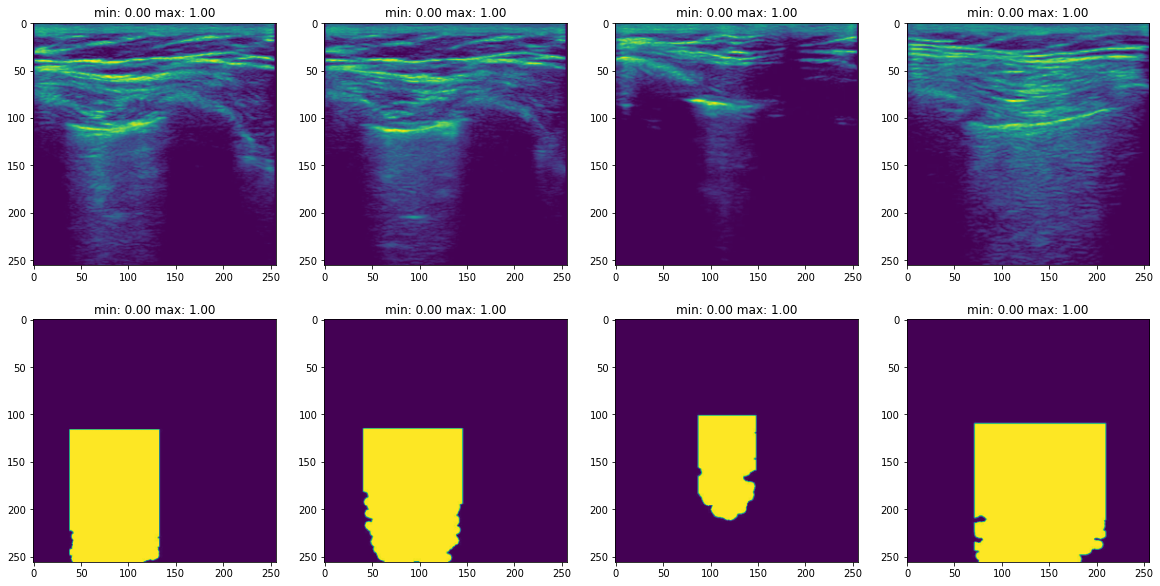

In [ ]:
unet = UNet(1,2)
min_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
    ])

dataset = LungSegDataset(dataset_dir=Path("/content/base_seg_dataset_2/"),
                         transform=min_transform)
fig, axs = plt.subplots(2, 4,figsize=(20,10))
sample = np.random.randint(0,len(dataset),64)
for i in range(4):
    img, target = dataset.__getitem__(sample[i])
    img = img.permute(1,2,0)
    axs[0,i].imshow(img[:,:,0])
    axs[0,i].set_title("min: {:.2f} max: {:.2f}".format(torch.min(target),torch.max(target)))
    axs[1,i].imshow(torch.squeeze(target))
    axs[1,i].set_title("min: {:.2f} max: {:.2f}".format(torch.min(target),torch.max(target)))

In [ ]:
batch_size =  3
split = (0.4, 0.3, 0.3)
training_samples = int(len(dataset) * split[0])
validation_samples = int(len(dataset) *  split[1])
test_samples = len(dataset) - training_samples - validation_samples
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (training_samples, validation_samples, test_samples))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

[ 1/10] train_loss: 0.59452 valid_loss: 0.68181 valid_acc: 58.74 %
Validation loss decreased (inf --> 0.681808).  Saving model ...
[ 2/10] train_loss: 0.48712 valid_loss: 0.52378 valid_acc: 80.74 %
Validation loss decreased (0.681808 --> 0.523777).  Saving model ...
[ 3/10] train_loss: 0.40098 valid_loss: 0.37608 valid_acc: 92.03 %
Validation loss decreased (0.523777 --> 0.376081).  Saving model ...
[ 4/10] train_loss: 0.32785 valid_loss: 0.29544 valid_acc: 92.97 %
Validation loss decreased (0.376081 --> 0.295438).  Saving model ...
[ 5/10] train_loss: 0.28274 valid_loss: 0.27923 valid_acc: 93.69 %
Validation loss decreased (0.295438 --> 0.279231).  Saving model ...
[ 6/10] train_loss: 0.25110 valid_loss: 0.38214 valid_acc: 84.90 %
EarlyStopping counter: 1 out of 3
[ 7/10] train_loss: 0.23607 valid_loss: 0.23267 valid_acc: 93.72 %
Validation loss decreased (0.279231 --> 0.232666).  Saving model ...
[ 8/10] train_loss: 0.20027 valid_loss: 0.21564 valid_acc: 93.89 %
Validation loss decre

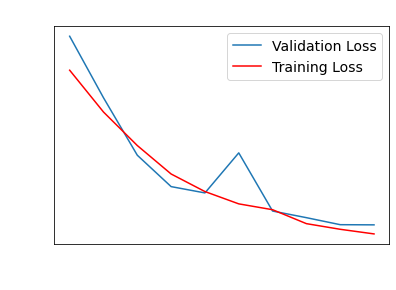

In [ ]:
unet = unet.to(device)
# mala by byt vahovana minimalne na zaklade distribucie tried.
criterion_CE = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(),lr=1e-3)

avg_valid_losses, avg_train_losses, model,batch_train_losses = train(unet,
                                                                     10,
                                                                     train_loader,
                                                                     valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer,
                                                                     early_stop_count=3)
visualize_loss(avg_valid_losses,avg_train_losses)
print_performance(unet,test_loader)

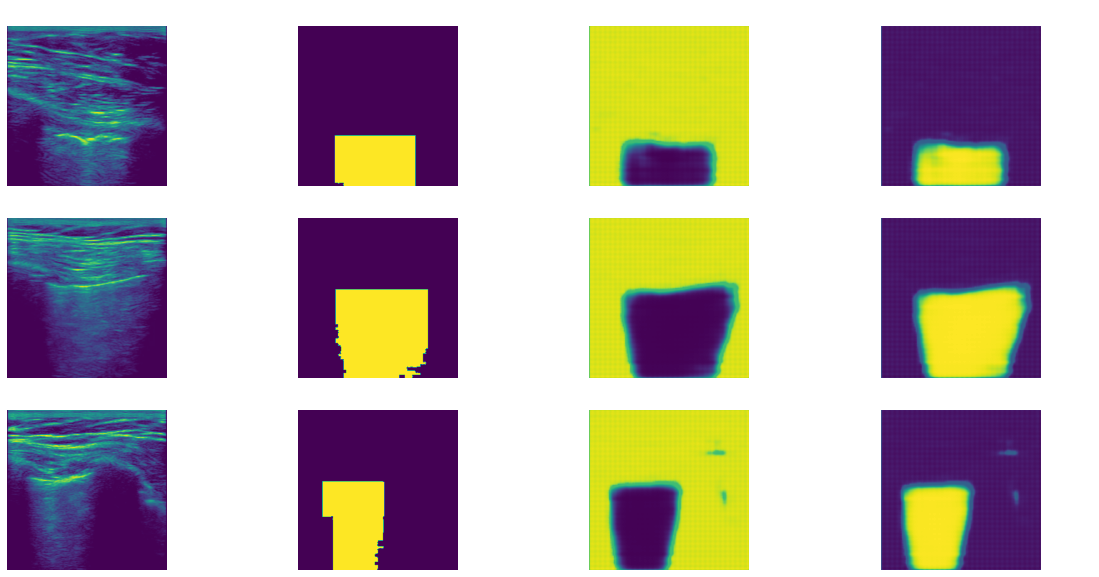

In [ ]:
visualize_prediction(unet,test_loader)

### Different loss functions
* https://github.com/JunMa11/SegLoss
* https://arxiv.org/abs/2006.14822v4
* certain loss function are unstable for tasks with noisy and unabalanced data

In [ ]:
from SegLoss.losses_pytorch.dice_loss import IoULoss,SoftDiceLoss,SSLoss

In [ ]:
unet = UNet(1,2)
unet = unet.to(device)

criterion = SSLoss()
optimizer = torch.optim.Adam(unet.parameters(),lr=1e-3)

avg_valid_losses, avg_train_losses, model,batch_train_losses = train(unet,
                                                                     20,
                                                                     train_loader,
                                                                     valid_loader,
                                                                     criterion=criterion,
                                                                     optimizer=optimizer,
                                                                     early_stop_count=5)
visualize_loss(avg_valid_losses,avg_train_losses)
print_performance(unet,test_loader)

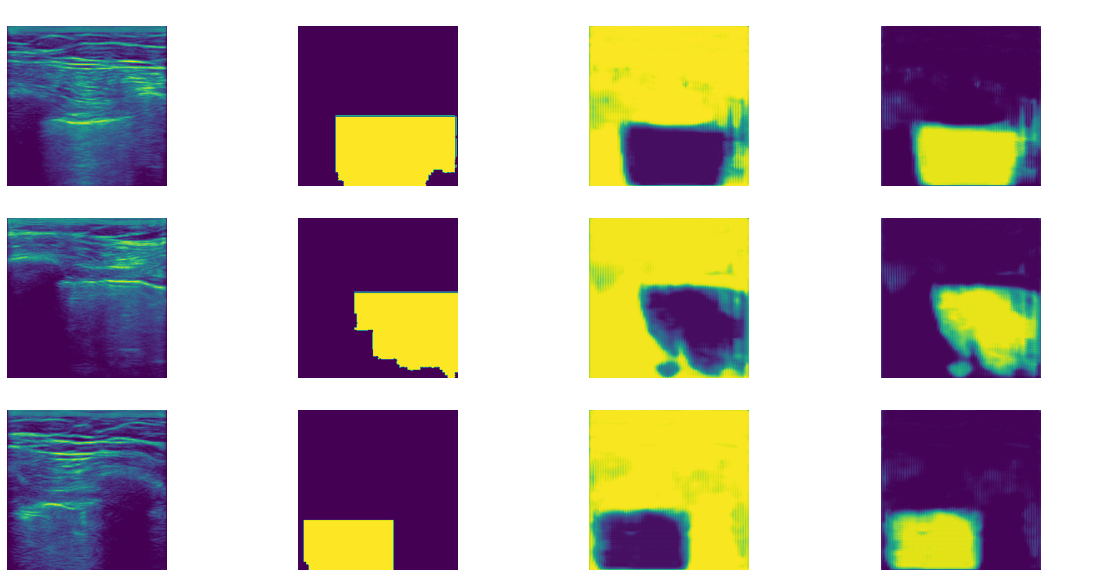

In [ ]:
visualize_prediction(unet,test_loader)

Task 1: Pridajte vahy podla distribucie tried do vypoctu chybovej funkcie, pre stabilizaciu ucenia.

Task 2: Navrhnite sposob ako zahrnut do chybovej funkcie hrany objektov.

Task 3: Vymyslite co najlepsiu postprocessing metodu na tkanivo pluca.

# Task 1

In [ ]:
back = 0
front = 0
for x,y in dataset:
    print(back, front)
    y = torch.flatten(y)
    for i in y:
        if i > 0.0:
            front+=1
        else:
            back+=1
            
front_w = back/(back+front)
back_w = front/(back+front)

[ 1/20] train_loss: 0.65815 valid_loss: 0.62683 valid_acc: 71.30 %
Validation loss decreased (inf --> 0.626826).  Saving model ...
[ 2/20] train_loss: 0.52399 valid_loss: 0.57273 valid_acc: 88.15 %
Validation loss decreased (0.626826 --> 0.572732).  Saving model ...
[ 3/20] train_loss: 0.44165 valid_loss: 0.41857 valid_acc: 93.89 %
Validation loss decreased (0.572732 --> 0.418574).  Saving model ...
[ 4/20] train_loss: 0.39923 valid_loss: 0.37082 valid_acc: 93.81 %
Validation loss decreased (0.418574 --> 0.370821).  Saving model ...
[ 5/20] train_loss: 0.36258 valid_loss: 0.45685 valid_acc: 91.24 %
EarlyStopping counter: 1 out of 5
[ 6/20] train_loss: 0.34085 valid_loss: 0.32963 valid_acc: 93.42 %
Validation loss decreased (0.370821 --> 0.329626).  Saving model ...
[ 7/20] train_loss: 0.31647 valid_loss: 0.30291 valid_acc: 93.82 %
Validation loss decreased (0.329626 --> 0.302906).  Saving model ...
[ 8/20] train_loss: 0.29691 valid_loss: 0.33984 valid_acc: 93.10 %
EarlyStopping counter

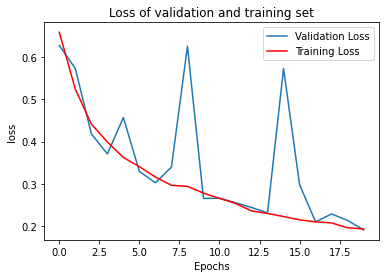

Accuracy:	0.9479
Recall:  	 0.9293
Precision	0.8467
Dice coef(F1)	0.8861
IoU	 0.7955



In [ ]:



unet = UNet(1,2)
unet = unet.to(device)

weights = torch.FloatTensor([back_w, front_w])
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(unet.parameters(),lr=1e-3)

avg_valid_losses, avg_train_losses, model,batch_train_losses = train(unet,
                                                                     20,
                                                                     train_loader,
                                                                     valid_loader,
                                                                     criterion=criterion,
                                                                     optimizer=optimizer,
                                                                     early_stop_count=5)
visualize_loss(avg_valid_losses,avg_train_losses)
print_performance(unet,test_loader)

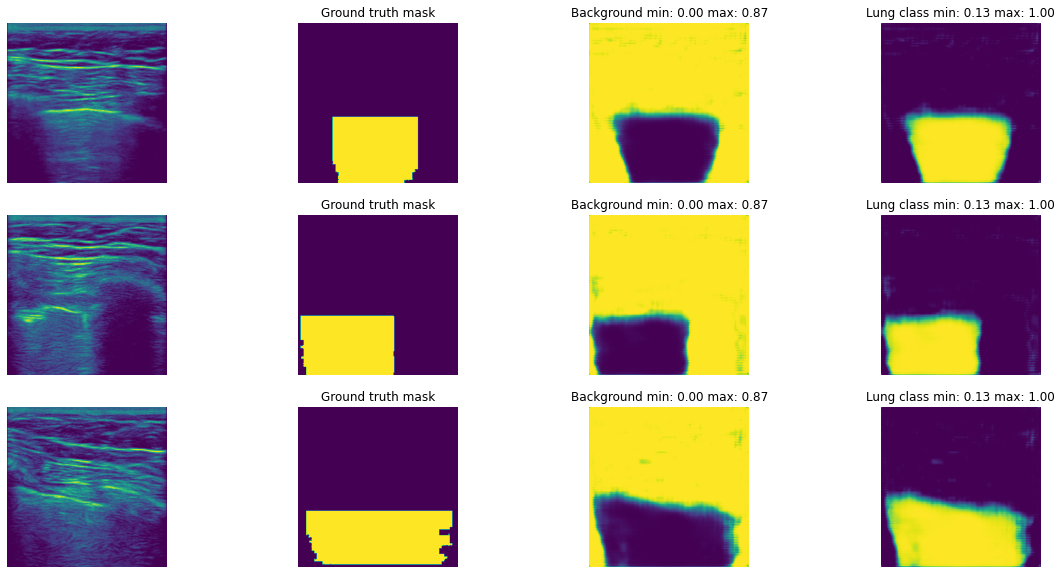

In [ ]:
visualize_prediction(unet,test_loader)